In [88]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import struct
import gzip
import os


In [89]:
def load_mnist(path="datasets/MNIST/raw"):
    for f in os.listdir(path):
        if 'train-images' in f:
            images = _load_images(os.path.join(path, f))
        elif 'train-labels' in f:
            labels = _load_labels(os.path.join(path, f))
    return images, labels


def _load_images(filepath):
    opener = gzip.open if filepath.endswith('.gz') else open
    with opener(filepath, 'rb') as f:
        f.read(4)
        n = struct.unpack('>I', f.read(4))[0]
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(n, 784).astype(np.float64)


def _load_labels(filepath):
    opener = gzip.open if filepath.endswith('.gz') else open
    with opener(filepath, 'rb') as f:
        f.read(8)
        return np.frombuffer(f.read(), dtype=np.uint8)


def group_by_class(features, labels):
    clusters = {}
    for k in range(10):
        clusters[k] = features[labels == k]
    return clusters


class MNISTBanditEnv:
    def __init__(self, clusters, target_class=0):
        self.clusters = clusters
        self.target_class = target_class
        self.K = 10
        self.d = 784
        self.reset()

    def reset(self):
        self.t = 0
        self.mistakes = 0
        self.cumulative_mistakes = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []

    def get_contexts(self):
        contexts = np.zeros((self.K, self.d))
        for k in range(self.K):
            idx = np.random.randint(len(self.clusters[k]))
            contexts[k] = self.clusters[k][idx] #это перестановки
        return contexts

    def step(self, action):
        self.t += 1

        if action == self.target_class:
            reward = 1.0
        else:
            reward = 0.0
            self.mistakes += 1
        regret = 1.0 - reward
        self.cumulative_regret += regret
        self.cumulative_regrets.append(self.cumulative_regret)
        self.cumulative_mistakes.append(self.mistakes)
        return reward


In [90]:
# Load and normalize
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([len(clusters[k]) for k in range(10)])

(60000, 784)
[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


In [91]:
class CBSCFD:
    def __init__(self, num_arms, lambd, beta, m, d):
        self.num_arms = num_arms
        self.d = d
        self.beta = beta
        self.alpha = lambd
        self.m = m

        self.theta = {a: np.zeros(self.d) for a in range(num_arms)}
        self.Z = {a: np.zeros((0, self.d)) for a in range(num_arms)}
        self.H = {a: None for a in range(num_arms)}
        self.H_prev = {a: None for a in range(num_arms)}
        self.sum_xy = {a: np.zeros(self.d) for a in range(num_arms)}
        self.alpha_per_arm = {a: lambd for a in range(num_arms)}
        self.t = 0

    def _apply_V_inv(self, x, a):
        if self.Z[a].shape[0] == 0:
            return x / self.alpha_per_arm[a]
        Zx = self.Z[a] @ x
        HZx = self.H[a] @ Zx
        ZT_HZx = self.Z[a].T @ HZx
        return (x - ZT_HZx) / self.alpha_per_arm[a]

    def update(self, user_context, a, r):
        self.t += 1
        x_t = user_context
        self.sum_xy[a] += x_t * r
        n_prev = self.Z[a].shape[0]
        self.Z[a] = np.vstack([self.Z[a], x_t.reshape(1, -1)])
        n = self.Z[a].shape[0]

        if n == 2 * self.m:
            self._svd_update(a)
        else:
            self._sequential_update(x_t, n_prev, a)

        self.theta[a] = self._apply_V_inv(self.sum_xy[a], a)

    def _svd_update(self, a):
        U, Sigma, Vt = svd(self.Z[a], full_matrices=False)
        if len(Sigma) >= self.m:
            delta_t = Sigma[self.m - 1] ** 2
        else:
            delta_t = 0
        self.alpha_per_arm[a] += delta_t
        Sigma_hat_sq = np.maximum(Sigma[:self.m] ** 2 - delta_t, 0)
        Sigma_hat = np.sqrt(Sigma_hat_sq)
        self.Z[a] = Sigma_hat.reshape(-1, 1) * Vt[:self.m, :]
        H_diag = 1.0 / (Sigma_hat_sq + self.alpha_per_arm[a])
        self.H[a] = np.diag(H_diag)
        self.H_prev[a] = self.H[a].copy()

    def _sequential_update(self, x_t, n_prev, a):
        n = self.Z[a].shape[0]
        if n == 1:
            k = np.dot(x_t, x_t) + self.alpha_per_arm[a]
            self.H[a] = np.array([[1.0 / k]])
            self.H_prev[a] = self.H[a]
        else:
            if self.H_prev[a] is None or self.H_prev[a].shape[0] != n_prev:
                self.H_prev[a] = np.eye(n_prev) / self.alpha_per_arm[a]
            Z_prev = self.Z[a][:n_prev, :]
            Z_prev_x = Z_prev @ x_t
            p = self.H_prev[a] @ Z_prev_x
            k_scalar = np.dot(x_t, x_t) - np.dot(Z_prev_x, p) + self.alpha_per_arm[a]
            self.H[a] = np.zeros((n, n))
            self.H[a][:n-1, :n-1] = self.H_prev[a] + np.outer(p, p) / k_scalar
            self.H[a][:n-1, n-1] = -p / k_scalar
            self.H[a][n-1, :n-1] = -p / k_scalar
            self.H[a][n-1, n-1] = 1.0 / k_scalar
            self.H_prev[a] = self.H[a]

    def score(self, user_context, arm):
        x = user_context
        mean = np.dot(self.theta[arm], x)
        var = np.dot(x, self._apply_V_inv(x, arm))
        return mean + self.beta * np.sqrt(max(var, 0))

In [92]:
from collections import defaultdict
class LinUCB:
    def __init__(self, num_arms, d, alpha, epsilon=1.0):
        self.num_arms = num_arms
        self.d = d

        self.alpha = alpha
        self.epsilon = epsilon


        self.D = defaultdict(list)
        self.b = defaultdict(list)

        self.A = defaultdict(lambda: self.epsilon * np.eye(self.d))
        self.A_inv = defaultdict(lambda: np.eye(self.d) / self.epsilon)
        self.rhs = defaultdict(lambda: np.zeros(self.d))
        self.theta = defaultdict(lambda: np.zeros(self.d, dtype=np.float32))



    def append_interaction(self, user_context, a, r):
        x_ua = user_context
        self.D[a].append(x_ua)
        self.b[a].append(r)

    def batch_update(self, arms=None):
        if arms is None:

            arms = self.D.keys()

        for a in arms:
            if len(self.D[a]) == 0:
                continue

            D_a = np.vstack(self.D[a])
            b_a = np.array(self.b[a])

            self.A[a] += D_a.T @ D_a
            self.A_inv[a] = np.linalg.inv(self.A[a])
            self.rhs[a] += D_a.T @ b_a

            self.theta[a] = self.A_inv[a] @ self.rhs[a]


        self.D.clear()
        self.b.clear()

    def score(self, user_context, arm):
        ctx = user_context
        mean = float(np.dot(self.theta[arm].T, ctx))
        exp = self.alpha * np.sqrt(np.dot(ctx.T, self.A_inv[arm] @ ctx))
        return mean + exp


In [134]:
def run_experiment_cbscfd(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)
    
    env = MNISTBanditEnv(clusters, target_class=0)
    bandit = CBSCFD(num_arms=10, lambd=lambd, beta=beta, m=m, d=784)
    
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)
    
    return env.cumulative_mistakes,env.cumulative_regrets

In [145]:
T = 4000
n_runs = 5
m = 10
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes, regrets = run_experiment_cbscfd(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/5


100%|██████████| 4000/4000 [00:01<00:00, 3867.24it/s]



Run 2/5


100%|██████████| 4000/4000 [00:01<00:00, 3792.52it/s]



Run 3/5


100%|██████████| 4000/4000 [00:01<00:00, 3827.63it/s]



Run 4/5


100%|██████████| 4000/4000 [00:01<00:00, 3879.62it/s]



Run 5/5


100%|██████████| 4000/4000 [00:01<00:00, 3866.73it/s]

num mistakes 53.0


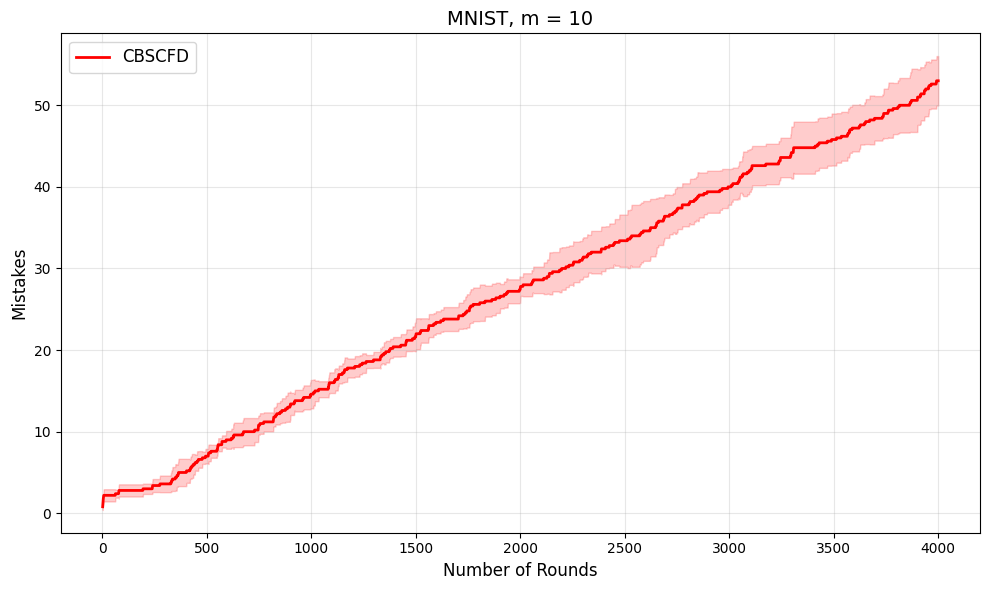

In [146]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='CBSCFD', color='red', linewidth=2)
plt.fill_between(rounds, 
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes, 
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [125]:
T = 1000
n_runs = 10
m = 10
lambd = 1
beta = 0.01

#all_mistakes = []
all_regrets = []

for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes, regrets = run_experiment(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    #all_mistakes.append(mistakes)
    all_regrets.append(regrets)

# all_mistakes = np.array(all_mistakes)
# mean_mistakes = np.mean(all_mistakes, axis=0)
# std_mistakes = np.std(all_mistakes, axis=0)
mean_regrets = np.mean(all_regrets, axis=0)

print(f"num reg {mean_regrets[-1]:.1f}")


Run 1/10


100%|██████████| 1000/1000 [00:00<00:00, 1648.82it/s]



Run 2/10


100%|██████████| 1000/1000 [00:00<00:00, 1631.31it/s]



Run 3/10


100%|██████████| 1000/1000 [00:00<00:00, 1659.16it/s]



Run 4/10


100%|██████████| 1000/1000 [00:00<00:00, 1601.45it/s]



Run 5/10


100%|██████████| 1000/1000 [00:00<00:00, 1590.21it/s]



Run 6/10


100%|██████████| 1000/1000 [00:00<00:00, 1597.99it/s]



Run 7/10


100%|██████████| 1000/1000 [00:00<00:00, 1640.66it/s]



Run 8/10


100%|██████████| 1000/1000 [00:00<00:00, 1601.40it/s]



Run 9/10


100%|██████████| 1000/1000 [00:00<00:00, 1626.62it/s]



Run 10/10


100%|██████████| 1000/1000 [00:00<00:00, 1575.77it/s]

num reg 2.1


Text(0.5, 1.0, 'Average Cumulative Regrets')

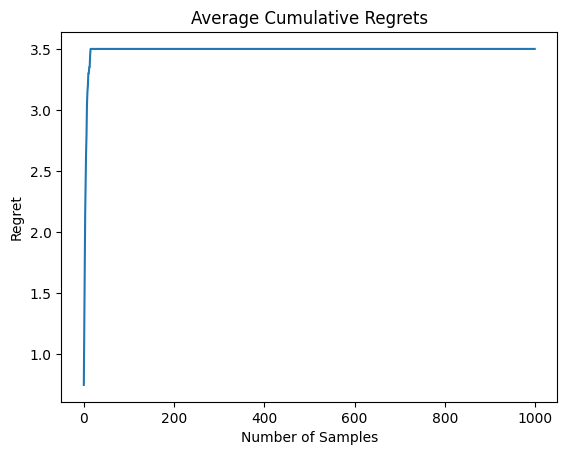

In [27]:
plt.plot(mean_regrets, label='CBSCFD')
plt.xlabel('Number of Samples')
plt.ylabel('Regret')
plt.title('Average Cumulative Regrets')

In [97]:
import numpy as np
from collections import defaultdict
from numpy.linalg import multi_dot
from scipy.linalg import svd, qr, norm
from math import sqrt

def integrator(tilde_Ut, S, tilde_Vt, delta_U, delta_V):
    #print("Integrator called")
    Ut = tilde_Ut.copy()
    Vt = tilde_Vt.copy()
    K1 = Ut @ S + delta_U.dot(delta_V.T.dot(Vt))
    tilde_U1, tilde_S1 = qr(K1,mode = "economic")
    tilde_S0 = tilde_S1 - tilde_U1.T.dot(delta_U.dot(delta_V.T.dot(Vt)))
    L1 = Vt.dot(tilde_S0.T) + delta_V.dot(delta_U.T.dot(tilde_U1))
    tilde_V1, S1 = qr(L1, mode = "economic")
    S1 = S1.T
    return tilde_U1, S1, tilde_V1

def svd_U_V_T(U, V, rank):
    Q_U, R_U = qr(U, mode = "economic")
    Q_V, R_V = qr(V, mode = "economic")

    U_svd, S_svd, V_svd = svd(R_U.dot(R_V.T), full_matrices = False)

    U_svd = U_svd[:, :rank]
    S_svd = S_svd[:rank]
    V_svd = V_svd[:rank, :]

    U_new = Q_U.dot(U_svd)
    V_new = V_svd.dot(Q_V.T)

    return U_new, np.diag(S_svd), V_new.T



class LinUCBwithPSI_rank1:
    def __init__(self, n_arms, d = 10, epsilon = 1.0, alpha = 1.0, rank = 10):
        self.n_arms = n_arms # количество ручек
        self.d = d # размерность контекстных векторов
        self.epsilon = epsilon # регуляризация
        self.sqrt_epsilon = 1 / sqrt(epsilon) # коэффициент для L_0^{-1}

        self.alpha = alpha # эскплорейшен
        self.rank = rank # малоранговое приближение

        self.U = defaultdict(lambda: np.empty((self.d, 0), dtype=np.float32))
        self.V = defaultdict(lambda: np.empty((self.d, 0), dtype=np.float32))

        self.first_time = defaultdict(lambda: False)
        #для  интегратора храним факторы с предыдущего шага
        self.Ut = defaultdict(lambda: None)
        self.St = defaultdict(lambda: None)
        self.Vt = defaultdict(lambda: None)

        self.b = defaultdict(lambda: np.zeros(self.d, dtype=np.float32)) # вектор наград
        self.theta = defaultdict(lambda: np.zeros(self.d, dtype=np.float32)) # оценка параметра

    def _L_matvec(self, vec, arm):

        L_0_inv_vec = self.sqrt_epsilon * vec.copy()
        return L_0_inv_vec - self.U[arm].dot(self.V[arm].T.dot(L_0_inv_vec))

    def update(self, user_context, arm, reward):

        self.b[arm] += reward * user_context

        bar_x = self._L_matvec(vec = user_context, arm = arm)

        norm_bar_x_sq = norm(bar_x) ** 2
        alpha_t = (sqrt(1 + norm_bar_x_sq) - 1) / norm_bar_x_sq
        beta_t = alpha_t / (1 + alpha_t * norm_bar_x_sq)

        self.U[arm], self.V[arm] = self._update_factors(bar_x=bar_x, beta_t=beta_t, arm=arm)

        self._update_theta(arm)

    def _update_u_and_v(self, x_bar, beta_t, arm):
        delta_u = beta_t * x_bar

        if self.V[arm].shape[1] > 0:
            delta_v = x_bar - self.V[arm] @ (self.U[arm].T @ x_bar)
        else:
            delta_v = x_bar

        return delta_u.reshape(-1, 1), delta_v.reshape(-1, 1)

    def _update_factors(self, bar_x, beta_t, arm):
        delta_U, delta_V = self._update_u_and_v(bar_x, beta_t, arm)
        if self.U[arm].shape[1] == 0:
            self.U[arm] = delta_U
            self.V[arm] = delta_V
            return self.U[arm], self.V[arm]
        elif self.U[arm].shape[1] < self.rank:
            self.U[arm] = np.column_stack([self.U[arm], delta_U])
            self.V[arm] = np.column_stack([self.V[arm], delta_V])
            return self.U[arm], self.V[arm]

        if self.Ut[arm] is None:
            self.Ut[arm], self.St[arm], self.Vt[arm] = svd_U_V_T(self.U[arm], self.V[arm], self.rank)
            #self.first_time[arm] = True
        self.Ut[arm], self.St[arm],  self.Vt[arm] = integrator(self.Ut[arm], self.St[arm], self.Vt[arm], delta_U, delta_V)

        return self.Ut[arm] @ self.St[arm],  self.Vt[arm]

    def _update_theta(self, arm):
        b_eps = self.epsilon * self.b[arm]

        term1 = b_eps
        term2 = self.V[arm].dot(self.U[arm].T.dot(b_eps))
        term3 = self.U[arm].dot(self.V[arm].T.dot(b_eps))
        term4 = self.V[arm].dot(self.U[arm].T.dot(term3))

        self.theta[arm] = term1 - term2 - term3 + term4

    def score(self, user_context, arm):
        """
        Compute the PSI-UCB score for a given user context and arm.
        """
        ctx = user_context
        mean = float(np.dot(self.theta[arm].T, ctx))
        v = self.V[arm].T @ ctx
        exp = (
            self.sqrt_epsilon
            * np.linalg.norm(ctx - (self.U[arm] @ v))
        )
        return mean + self.alpha * exp



In [128]:
def run_experiment_psi(clusters, T=4000, lambd=0.02, beta=0.01, m=10, seed=0):

    np.random.seed(seed)

    env = MNISTBanditEnv(clusters, target_class=0)
    bandit = LinUCBwithPSI_rank1(n_arms=10,d=784, epsilon=lambd, alpha=beta, rank=m)
    for t in trange(T):
        contexts = env.get_contexts()
        scores = [bandit.score(contexts[a], a) for a in range(10)]
        action = int(np.argmax(scores))
        reward = env.step(action)
        bandit.update(contexts[action], action, reward)

    return env.cumulative_mistakes,env.cumulative_regrets

In [152]:
T = 4000
n_runs = 1
m = 64
lambd = 1
beta = 1

all_mistakes = []


for run in range(n_runs):
    print(f"\nRun {run+1}/{n_runs}")
    mistakes, regrets = run_experiment_psi(clusters, T=T, lambd=lambd, beta=beta, m=m, seed=run)
    all_mistakes.append(mistakes)


all_mistakes = np.array(all_mistakes)
mean_mistakes = np.mean(all_mistakes, axis=0)
std_mistakes = np.std(all_mistakes, axis=0)


print(f"num mistakes {mean_mistakes[-1]:.1f}")


Run 1/1


100%|██████████| 4000/4000 [00:15<00:00, 262.19it/s]

num mistakes 23.0


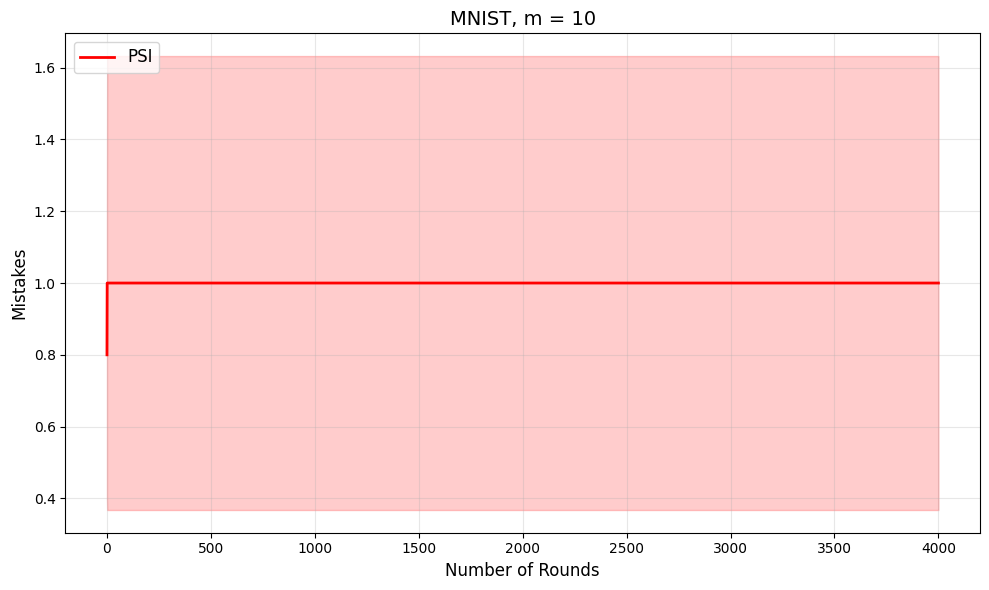

In [142]:
plt.figure(figsize=(10, 6))

rounds = np.arange(1, T + 1)

plt.plot(rounds, mean_mistakes, label='PSI', color='red', linewidth=2)
plt.fill_between(rounds,
                 mean_mistakes - std_mistakes,
                 mean_mistakes + std_mistakes,
                 alpha=0.2, color='red')

plt.xlabel('Number of Rounds', fontsize=12)
plt.ylabel('Mistakes', fontsize=12)
plt.title('MNIST, m = 10', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
def integrator(U0, S0, V0, U, V):
    K1 = U0 @ S0 + multi_dot([U, V.T, V0])
    U1, S1_bar = np.linalg.qr(K1)
    S0_tilde = S1_bar - multi_dot([U1.T, U, V.T, V0])
    # S0_tilde = S1_bar - U1.T @ (U @ V.T  - U0 @ S0 @ V0.T) @ V0
    # L1 = V0 @ S0_tilde.T + (U1 @ V1.T  - U0 @ S0 @ V0.T).T @ U1
    L1 = V0 @ S0_tilde.T + multi_dot([V, U.T, U1])
    V1, S1_T = np.linalg.qr(L1)
    S1 = S1_T.T

    return U1, S1, V1





def getStartingValues1(u, v, k):
    Qu, Ru = np.linalg.qr(u) #d B
    Qv, Rv = np.linalg.qr(v)
    small_matrix = Ru @ Rv.T
    U_s, S, Vh_s = np.linalg.svd(small_matrix, full_matrices=False)
    U_s = U_s[:, :k]
    S = S[:k]
    S = np.diag(S.T)
    Vh_s = Vh_s[:k, :]
    U = Qu @ U_s
    V = Qv @ Vh_s.T
    return U, S, V


def getStartingValues(u, v, k):
    Qu, Ru = np.linalg.qr(u)
    Qv, Rv = np.linalg.qr(v)


    small_matrix = Ru @ Rv.T

    try:
        U_s, S, Vh_s = np.linalg.svd(small_matrix, full_matrices=False)
    except np.linalg.LinAlgError:

        print('reg')
        reg = 1e-10 * np.eye(small_matrix.shape[0])
        small_matrix_reg = small_matrix + reg
        U_s, S, Vh_s = np.linalg.svd(small_matrix_reg, full_matrices=False)

    U_s = U_s[:, :k]
    S = S[:k]
    S = np.diag(S)
    Vh_s = Vh_s[:k, :]

    U = Qu @ U_s
    V = Qv @ Vh_s.T
    #print(U.shape)
    #print( U, S, V)

    return U, S, V




def symmetric_factorization_ambikassaran_qr(X_bar):
    d, B = X_bar.shape  # x_bar

    # print(X_Bar.shape)
    Q, R = np.linalg.qr(X_bar)
    # print(R.shape)

    T = np.eye(B) + R @ R.T
    M = np.linalg.cholesky(T)

    Y_tB = (M - np.eye(B))
    return Y_tB, Q


class LinUCBwithPSI_Batch:
    def __init__(self, num_arms, d, epsilon: 1.0,
                 alpha: 1, rank: 10):

        self.d = d

        self.num_arms = num_arms
        self.epsilon = epsilon
        self.alpha = alpha
        self.rank = rank

        self.eps = 1 / np.sqrt(epsilon)

        self.U = defaultdict(lambda: np.empty((self.d, 0), dtype=np.float32))
        self.V = defaultdict(lambda: np.empty((self.d, 0), dtype=np.float32))
        self.U_psi = defaultdict(lambda: None)
        self.V_psi = defaultdict(lambda: None)
        self.S_psi = defaultdict(lambda: None)
        self.b = defaultdict(lambda: np.zeros(self.d, dtype=np.float32))
        self.theta = defaultdict(lambda: np.zeros(self.d, dtype=np.float32))

        self.X_batch = defaultdict(list)
        self.rewards_batch = defaultdict(list)
        self.update_times = []
        self.t = 0
        self.batch_count = 0


    def append_by_arm(self, user_context, arm, r):
        x_ua = user_context

        self.X_batch[arm].append(x_ua)
        self.rewards_batch[arm].append(r)



    def batch_update(self, arms=None):
        if arms is None:
            arms = self.X_batch.keys()

        arms_updated = 0

        for arm in arms:
            if len(self.X_batch[arm]) == 0:
                continue

            arms_updated += 1

            X_batch = np.column_stack(self.X_batch[arm])  # d \times B
            rewards = np.array(self.rewards_batch[arm])

            self.b[arm] += X_batch @ rewards

            X_bar = (X_batch -
                     multi_dot([self.U[arm], self.V[arm].T, X_batch])) * self.eps

            try:
                Y_tB, Q = symmetric_factorization_ambikassaran_qr(X_bar)


                Y_tB_inv = np.linalg.inv(Y_tB+ 1e-10 * np.eye(X_bar.shape[1]))
                C = np.linalg.inv(Y_tB_inv + np.eye(Y_tB.shape[0]))


            except np.linalg.LinAlgError as e:
                print(e)
                continue




            self.U[arm], self.V[arm] = self._apply_psi_batch(arm, Q, C)

            L0_inv_b = self.eps * self.b[arm]
            V_T_L0_inv = self.V[arm].T * self.eps

            self.theta[arm] = (L0_inv_b * self.eps
                               - self.eps * multi_dot([self.U[arm], V_T_L0_inv, self.b[arm]])
                               - self.eps * multi_dot([self.V[arm], self.U[arm].T, L0_inv_b])
                               + self.eps * multi_dot(
                        [self.V[arm], self.U[arm].T, self.U[arm], V_T_L0_inv, self.b[arm]]))

        self.X_batch.clear()
        self.rewards_batch.clear()
        self.batch_count += 1



    def _update_u_and_v(self, arm, Q, C):
         #current_cols = self.U[arm].shape[1] if self.U[arm].size > 0 else 0
         U_update = Q @ C

         if self.V[arm].size > 0:

             V_update = Q - multi_dot([self.V[arm], self.U[arm].T, Q])
         else:
             V_update = Q

         return U_update, V_update



    def _apply_psi_batch(self, arm, Q, C):
        current_cols = self.U[arm].shape[1]
        U_update, V_update = self._update_u_and_v(arm, Q, C)

        if current_cols < self.rank:
            self.U[arm] = np.column_stack([self.U[arm], U_update]) if current_cols > 0 else U_update
            self.V[arm] = np.column_stack([self.V[arm], V_update]) if current_cols > 0 else V_update
            #print('stuck')
            return self.U[arm], self.V[arm]


        elif self.U_psi[arm] is None:
            #print('stop')
            U0, S0, V0 = getStartingValues(self.U[arm], self.V[arm], self.rank)
            self.U_psi[arm] = U0
            self.S_psi[arm] = S0
            self.V_psi[arm] = V0
            #return U0 @ S0, V0


        #print("int")

        self.U_psi[arm], self.S_psi[arm], self.V_psi[arm] = integrator(
                self.U_psi[arm], self.S_psi[arm], self.V_psi[arm],
                U_update, V_update)

        return self.U_psi[arm] @ self.S_psi[arm], self.V_psi[arm]

    def score(self, user_context, arm):
        """
        Compute the PSI-UCB score for a given user context and arm.
        """
        ctx = user_context
        mean = float(np.dot(self.theta[arm].T, ctx))
        v = self.V[arm].T @ ctx
        exp = (
            np.sqrt(self.epsilon)
            * np.linalg.norm(ctx - (self.U[arm] @ v))
        )
        return mean + self.alpha * exp

